# SIMPLE RBA algorithm
For comparison purposes, we also implement the SIMPLE risk-based algorithm, as described by Wiefling et al.:


> The simple model (SIMPLE) extends the single-feature model used in the open source single sign-on solution OpenAM [31] and is assumed to be used at GOG.com [46]. It also partly reflects models given in literature [42,24,16]. We based our implementation on OpenAM, since it is freely available and probably widely used. The SIMPLE algorithm checks a number of features for an exact match in the user’s login history. The risk score is the number of inspected features with at least one match in the login history divided by the total number of considered features. Thus, the risk score granularity increases with the number of observed features.

Source: [What’s in Score for Website Users: A Data-Driven Long-Term Study on Risk-Based Authentication Characteristics](https://www.stephanwiefling.de/papers/rba-characteristics-fc2021.pdf)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/rba-dataset.zip

Archive:  /content/drive/MyDrive/rba-dataset.zip
  inflating: LICENSE                 
  inflating: README.md               
  inflating: RESULTS.md              
   creating: images/
  inflating: images/login-overview.png  
  inflating: images/rq1-general.png  
  inflating: images/rq1-login-frequency.png  
  inflating: images/rq2-attack-data.png  
  inflating: images/rq6-rtt-0_999.png  
  inflating: images/rtts-continents.png  
  inflating: images/rtts-global.png  
  inflating: rba-dataset.csv         


# Import Libraries
This cell imports all the required libraries and modules needed for data manipulation, visualization, and evaluation.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report

# Data Loading Function
This cell defines a function to load and prepare the dataset. The dataset is read from a CSV file, indexed by login timestamps, and only a subset of the data is loaded for efficiency.

In [4]:
def load_data():
    df = pd.read_csv(
        "/content/rba-dataset.csv",
        index_col="Login Timestamp",
        parse_dates=True,
        nrows=100000
    )
    return df

# SIMPLE RBA Algorithm Implementation
This cell contains the core implementation of the SIMPLE algorithm. It processes each user’s login history to compute a risk score based on predefined features.

**Features Considered:**

The algorithm uses features such as IP Address, Country, ASN, Device Type, Browser Name and Version, and OS Name and Version.

**Processing:**

* The data is grouped by user to handle each user’s login attempts in chronological order.

* For each login attempt, the algorithm checks if the feature values have been seen before (using a history maintained in a dictionary).

* The risk score is computed as the ratio of matching features to the total number of features.

**Output:**

The function returns a DataFrame containing the timestamp, user ID, risk score, and a label indicating if the login was successful (legitimate) or an attack.

In [5]:
def simple_rba_algorithm(df):
    # Define features to consider
    features = [
        'IP Address',
        'Country',
        'ASN',
        'Device Type',
        'Browser Name and Version',
        'OS Name and Version'
    ]

    # Initialize results storage
    results = []

    # Process each user individually
    for user_id, user_logs in df.groupby('User ID'):
        user_logs = user_logs.sort_index()

        # Track seen values for each feature
        feature_history = {feature: set() for feature in features}

        for timestamp, login_attempt in user_logs.iterrows():
            matches = 0
            for feature in features:
                current_value = login_attempt[feature]
                if current_value in feature_history[feature]:
                    matches += 1
                # Update history with current value for future logins
                feature_history[feature].add(current_value)

            risk_score = matches / len(features)
            results.append({
                'timestamp': timestamp,
                'user_id': user_id,
                'risk_score': risk_score,
                'label': 0 if login_attempt['Login Successful'] else 1  # Attack=1, Legit=0
            })

    return pd.DataFrame(results).set_index('timestamp')

# Evaluation and Visualization
This cell defines a function to evaluate the performance of the SIMPLE algorithm using ROC curves, AUC-ROC, confusion matrix, and Equal Error Rate (EER).

In [9]:
def evaluate_performance(results_df):
    y_true = results_df['label']
    y_scores = results_df['risk_score']

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    # Calculate EER
    fnr = 1 - tpr
    eer_idx = np.nanargmin(np.abs(fpr - fnr))
    eer = (fpr[eer_idx] + fnr[eer_idx]) / 2
    eer_threshold = thresholds[eer_idx]

    # Generate predictions at EER threshold
    y_pred = (y_scores >= eer_threshold).astype(int)

    # 1) Plot FAR vs. FRR vs. Threshold
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, fpr, label="False Acceptance Rate (FAR)", color="red")
    plt.plot(thresholds, fnr, label="False Rejection Rate (FRR)", color="blue")
    plt.axvline(eer_threshold, color="black", linestyle="--", label=f"EER={eer:.2f} @ {eer_threshold:.2f}")
    plt.xlabel("Risk Score Threshold")
    plt.ylabel("Error Rate")
    plt.title("FAR, FRR, and EER for SIMPLE Algorithm")
    plt.legend()
    plt.grid()
    plt.show()

    # 2) Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legit', 'Attack'],
                yticklabels=['Legit', 'Attack'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix for SIMPLE Algorithm")
    plt.show()

    # 3) Plot ROC Curve
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.scatter(fpr[eer_idx], tpr[eer_idx], color='red',
                label=f"EER={eer:.2f} @ {eer_threshold:.2f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for SIMPLE Algorithm")
    plt.legend()
    plt.grid()
    plt.show()

    # 4) Print EER, AUC, and Classification Report
    print(f"\nEqual Error Rate (EER): {eer:.4f} @ threshold={eer_threshold:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Legit', 'Attack']))

# Main Execution
This cell orchestrates the execution of the above functions by loading the data, running the SIMPLE algorithm, and evaluating its performance.

Loading data...
Calculating risk scores...
Evaluating performance...


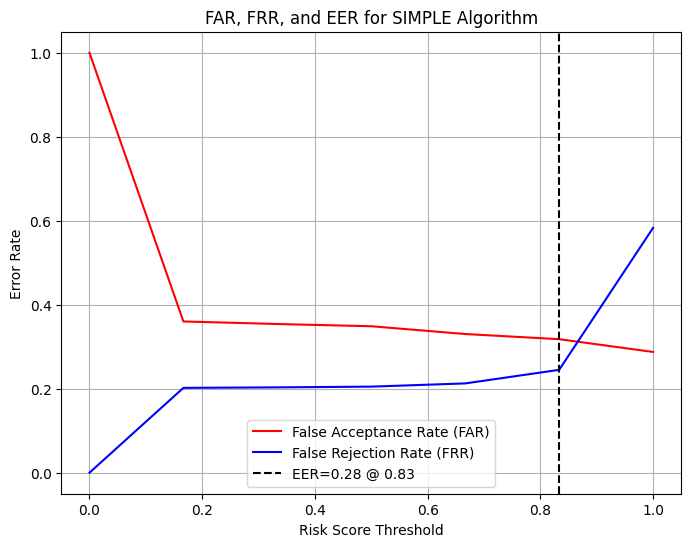

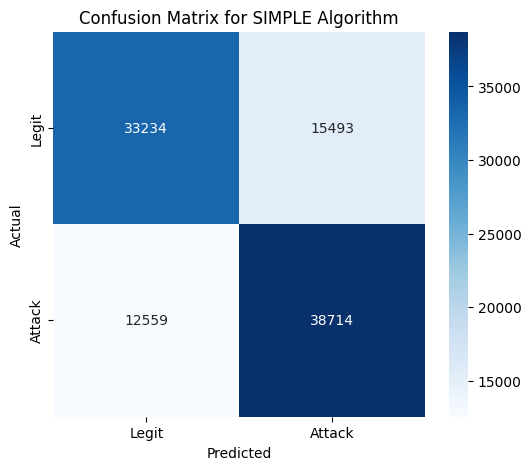

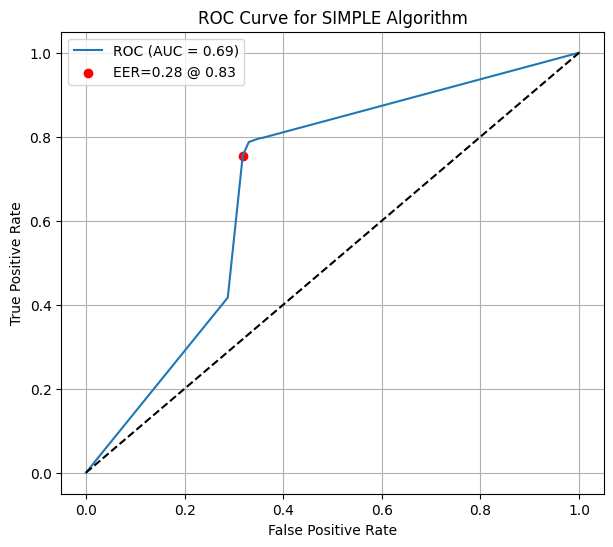


Equal Error Rate (EER): 0.2814 @ threshold=0.8333
AUC-ROC: 0.6862

Classification Report:
              precision    recall  f1-score   support

       Legit       0.73      0.68      0.70     48727
      Attack       0.71      0.76      0.73     51273

    accuracy                           0.72    100000
   macro avg       0.72      0.72      0.72    100000
weighted avg       0.72      0.72      0.72    100000



In [10]:
if __name__ == "__main__":
    print("Loading data...")
    df = load_data()

    print("Calculating risk scores...")
    results_df = simple_rba_algorithm(df)

    print("Evaluating performance...")
    evaluate_performance(results_df)

In [8]:
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report

# Load and prepare data
def load_data():
    df = pd.read_csv(
        "/content/rba-dataset.csv",
        index_col="Login Timestamp",
        parse_dates=True,
        nrows=100000
    )
    return df

# SIMPLE RBA Algorithm Implementation
def simple_rba_algorithm(df):
    # Define features to consider
    features = [
        'IP Address',
        'Country',
        'ASN',
        'Device Type',
        'Browser Name and Version',
        'OS Name and Version'
    ]

    # Initialize results storage
    results = []

    # Process each user individually
    for user_id, user_logs in df.groupby('User ID'):
        user_logs = user_logs.sort_index()

        # Track seen values for each feature
        feature_history = {feature: set() for feature in features}

        for timestamp, login_attempt in user_logs.iterrows():
            matches = 0
            for feature in features:
                current_value = login_attempt[feature]
                if current_value in feature_history[feature]:
                    matches += 1
                # Update history with current value for future logins
                feature_history[feature].add(current_value)

            risk_score = matches / len(features)
            results.append({
                'timestamp': timestamp,
                'user_id': user_id,
                'risk_score': risk_score,
                'label': 0 if login_attempt['Login Successful'] else 1  # Attack=1, Legit=0
            })

    return pd.DataFrame(results).set_index('timestamp')

# Evaluation and visualization
def evaluate_performance(results_df):
    y_true = results_df['label']
    y_scores = results_df['risk_score']

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)

    # Calculate EER
    fnr = 1 - tpr
    eer_idx = np.nanargmin(np.abs(fpr - fnr))
    eer = (fpr[eer_idx] + fnr[eer_idx]) / 2
    eer_threshold = thresholds[eer_idx]

    # Generate predictions at EER threshold
    y_pred = (y_scores >= eer_threshold).astype(int)

    # 1) Plot FAR vs. FRR vs. Threshold
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, fpr, label="False Acceptance Rate (FAR)", color="red")
    plt.plot(thresholds, fnr, label="False Rejection Rate (FRR)", color="blue")
    plt.axvline(eer_threshold, color="black", linestyle="--", label=f"EER={eer:.2f} @ {eer_threshold:.2f}")
    plt.xlabel("Risk Score Threshold")
    plt.ylabel("Error Rate")
    plt.title("FAR, FRR, and EER for SIMPLE Algorithm")
    plt.legend()
    plt.grid()
    plt.show()

    # 2) Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Legit', 'Attack'],
                yticklabels=['Legit', 'Attack'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix @ Threshold={eer_threshold:.2f}")
    plt.show()

    # 3) Plot ROC Curve
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.scatter(fpr[eer_idx], tpr[eer_idx], color='red',
                label=f"EER={eer:.2f} @ {eer_threshold:.2f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("SIMPLE Algorithm ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # 4) Print EER, AUC, and Classification Report
    print(f"\nEqual Error Rate (EER): {eer:.4f} @ threshold={eer_threshold:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Legit', 'Attack']))

# Main execution
if __name__ == "__main__":
    print("Loading data...")
    df = load_data()

    print("Calculating risk scores...")
    results_df = simple_rba_algorithm(df)

    print("Evaluating performance...")
    evaluate_performance(results_df)
'''

'\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report\n\n# Load and prepare data\ndef load_data():\n    df = pd.read_csv(\n        "/content/rba-dataset.csv",\n        index_col="Login Timestamp",\n        parse_dates=True,\n        nrows=100000  \n    )\n    return df\n\n# SIMPLE RBA Algorithm Implementation\ndef simple_rba_algorithm(df):\n    # Define features to consider\n    features = [\n        \'IP Address\',\n        \'Country\',\n        \'ASN\',\n        \'Device Type\',\n        \'Browser Name and Version\',\n        \'OS Name and Version\'\n    ]\n    \n    # Initialize results storage\n    results = []\n    \n    # Process each user individually\n    for user_id, user_logs in df.groupby(\'User ID\'):\n        user_logs = user_logs.sort_index()\n        \n        # Track seen values for each feature\n        feature_history = {feature: 